In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable
import random
import torchvision
import torchvision.transforms as transforms
from source.utils import Class_Dataset, EarlyStopping
from tqdm import tqdm
from source.neural_integral_operator import integral_operator
from source.models import G_global, NN_feedforward, ConvNeuralNet1D
from source.integrators import MonteCarlo

use_cuda = torch.cuda.is_available()

In [2]:
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"

In [3]:
dim = 3
batch_size = 4
mc = MonteCarlo()
mc_samplings=3000
enc_dim = 16 #16

In [4]:
freq_length = 800 #800

In [5]:
encoder = torch.nn.Conv1d(
    1,
    enc_dim+1,
    [32],#32
    stride= 16,#16
    ).to(device)

In [6]:
# encoder = ConvNeuralNet1D(dim=1,out_dim=enc_dim+1,K1=[4,4],K2=[4,4]).to(device)

In [7]:
shapes = encoder(torch.rand(batch_size,freq_length,1).permute(0,2,1).to(device)).shape

In [8]:
shapes

torch.Size([4, 17, 49])

In [9]:
times = torch.linspace(0,1,shapes[2]).to(device)

In [10]:
G = G_global(enc_dim,enc_dim,[8,8]).to(device) #[8,8]

In [11]:
model = integral_operator(enc_dim, times, G, mc, num_internal_points=times.shape[0],mc_samplings=mc_samplings).to(device)

In [12]:
decoder = NN_feedforward(enc_dim,dim,[8]).to(device) #[4] and [8]

In [13]:
import mat73

In [14]:
X = mat73.loadmat('Textile_data.mat')

In [15]:
X

{'Xcal': array([[0.20952877, 0.20952852, 0.20952816, ..., 0.55225384, 0.55150455,
         0.55018751],
        [0.26161383, 0.26161864, 0.26162608, ..., 0.63818077, 0.63828429,
         0.63846234],
        [0.20427742, 0.20428556, 0.20429807, ..., 0.40606632, 0.40565926,
         0.40493866],
        ...,
        [0.4582676 , 0.45768569, 0.45666336, ..., 0.69730763, 0.69741541,
         0.69760021],
        [0.29329523, 0.29301262, 0.29251603, ..., 0.47155035, 0.47127744,
         0.47071314],
        [0.29147779, 0.29148722, 0.29150385, ..., 0.44283046, 0.44282045,
         0.44278334]]),
 'Xcal1': array([[0.20427742, 0.20428556, 0.20429807, ..., 0.40606632, 0.40565926,
         0.40493866],
        [0.4705665 , 0.47062252, 0.47070835, ..., 0.76692402, 0.76674529,
         0.76637765],
        [0.11052942, 0.11054044, 0.11055737, ..., 0.46988475, 0.46960006,
         0.46902599],
        ...,
        [0.41966933, 0.41967684, 0.41969004, ..., 0.59318143, 0.59274151,
         0.591948

In [16]:
data1, data2 = torch.from_numpy(X['Xcal']).unsqueeze(-1), torch.from_numpy(X['Xpred']).unsqueeze(-1)

In [17]:
lab1, lab2 = torch.from_numpy(X['Ycal']), torch.from_numpy(X['Ypred'])

In [18]:
Data = torch.cat([data1, data2], dim=0)

In [19]:
Data.shape

torch.Size([223, 2800, 1])

In [20]:
Cls = torch.cat([lab1, lab2], dim=0) - 1

In [21]:
offset = 1000 #1000

In [22]:
Data = Data[:,-offset:-offset+freq_length,:]  #[:,-1000:-1000+800,:]

In [23]:
Data = torch.nn.functional.normalize(Data,p=153).to(device).float()

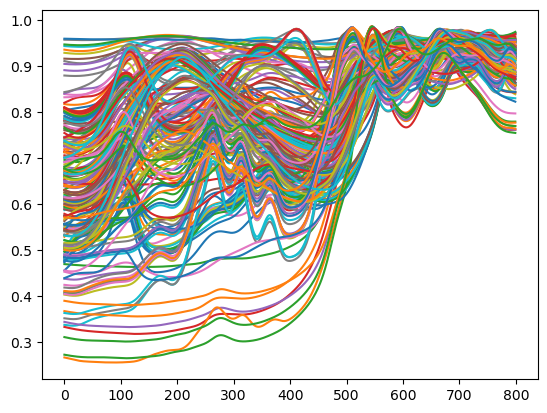

In [24]:
#Visualize
for i in range(Data.shape[0]):
    plt.plot(Data[i,:,0].cpu())
    plt.show

In [25]:
Cls = Cls.unsqueeze(-1).to(device).float()

In [26]:
zeros = 0
ones = 0
twos = 0
for i in range(Cls.shape[0]):
    if Cls[i] == 0:
        zeros += 1
    elif Cls[i]==1:
        ones += 1
    else:
        twos+=1
print(zeros, ones, twos)

54 123 46


In [27]:
Cls.shape[0], Data.shape[0]

(223, 223)

In [28]:
# max, length = 30, 8
# Data_class2 = torch.tensor([]).to(device)
# Data_class1 = torch.tensor([]).to(device)
# Data_class3 = torch.tensor([]).to(device)
# Cls_class2 = torch.tensor([]).to(device)
# Cls_class1 = torch.tensor([]).to(device)
# Cls_class3 = torch.tensor([]).to(device)


# for i in range(Cls.shape[0]):
#     if Cls[i] == 1:
#         Data_class2 = torch.cat([Data_class2,Data[i:i+1]],dim=0)
#         Cls_class2 = torch.cat([Cls_class2,Cls[i]],dim=0)
#     elif Cls[i] == 0:
#         Data_class1 = torch.cat([Data_class1,Data[i:i+1]],dim=0)
#         Cls_class1 = torch.cat([Cls_class1,Cls[i]],dim=0)
#     elif Cls[i] ==2:
#         Data_class3 = torch.cat([Data_class3,Data[i:i+1]],dim=0)
#         Cls_class3 = torch.cat([Cls_class3,Cls[i]],dim=0)

# Data_train = torch.cat([Data_class1[:max], Data_class2[:max], Data_class3[:max]])
# Cls_train = torch.cat([Cls_class1[:max], Cls_class2[:max], Cls_class3][:max])

# Data_valid = torch.cat([Data_class1[max:max+length], Data_class2[max:max+length], Data_class3[max:max+length]])
# Cls_valid = torch.cat([Cls_class1[max:max+length], Cls_class2[max:max+length], Cls_class3[max:max+length]])

# Data_test = torch.cat([Data_class1[max+length:max+2*length], Data_class2[max+length:max+2*length], Data_class3[max+length:max+2*length]])
# Cls_test = torch.cat([Cls_class1[max+length:max+2*length], Cls_class2[max+length:max+2*length], Cls_class3[max+length:max+2*length]])


# Cls_train = Cls_train.type(torch.LongTensor).squeeze()
# Cls_valid = Cls_valid.type(torch.LongTensor).squeeze()
# Cls_test = Cls_test.type(torch.LongTensor).squeeze()

In [29]:
test_factor = 0.1 #0.1

In [30]:
permutation = torch.randperm(Data.shape[0])
#print(permutation)
print(int(test_factor*Data.shape[0]))

Data = Data[permutation,...]
Cls = Cls[permutation,...]

Data_train = Data[:-2*int(test_factor*Data.shape[0]),...].to(device)
Cls_train = Cls[:-2*int(test_factor*Data.shape[0]),...].type(torch.LongTensor).squeeze(-1).to(device)
Data_valid = Data[-2*int(test_factor*Data.shape[0]):-int(test_factor*Data.shape[0]),...].to(device)
Cls_valid = Cls[-2*int(test_factor*Data.shape[0]):-int(test_factor*Data.shape[0]),...].type(torch.LongTensor).squeeze(-1).to(device)


Data_test = Data[-int(test_factor*Data.shape[0]):,...].to(device)
Cls_test = Cls[-int(test_factor*Data.shape[0]):,...].type(torch.LongTensor).squeeze(-1).to(device)


zeros = 0
ones = 0
twos = 0
for i in range(Cls_valid.shape[0]):
    if Cls_valid[i] == 0:
        zeros += 1
    elif Cls_valid[i]==1:
        ones += 1
    else:
        twos+=1
print("Labels validation: ", zeros, ones, twos)


zeros = 0
ones = 0
twos = 0
for i in range(Cls_test.shape[0]):
    if Cls_test[i] == 0:
        zeros += 1
    elif Cls_test[i]==1:
        ones += 1
    else:
        twos+=1
print("Labels test: ", zeros, ones, twos)


22
Labels validation:  6 11 5
Labels test:  5 15 2


In [31]:

train_loader = torch.utils.data.DataLoader(
                                   Class_Dataset(Data_train, Cls_train),
                                   batch_size=batch_size, 
                                   shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
                                   Class_Dataset(Data_valid, Cls_valid),
                                   batch_size=batch_size, 
                                   shuffle=True
)

test_loader = torch.utils.data.DataLoader(
                                   Class_Dataset(Data_test, Cls_test), 
                                   batch_size=1,
                                   shuffle=True
)


# if args.mode == 'train':
#     dataloaders = {'train': train_loader,
#                    'val': valid_loader,
#                   }
# else:
#     dataloaders = {
#                    'test': test_loader,
#                   }

In [32]:
def flatten_kernel_parameters(kernel):
    p_shapes = []
    flat_parameters = []
    for p in kernel.parameters():
        p_shapes.append(p.size())
        flat_parameters.append(p.flatten())
    return torch.cat(flat_parameters)

In [33]:
flatten_kernel_parameters(model).shape[0] + flatten_kernel_parameters(encoder).shape[0] + flatten_kernel_parameters(decoder).shape[0]

1092

In [ ]:
patience = 10
factor = 0.1

In [ ]:
All_parameters = list(model.parameters()) + list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(All_parameters, lr=1e-3, weight_decay=1e-4) #1e-3
criterion = nn.CrossEntropyLoss()
scheduler = \
torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=101, eta_min=1e-6) #1e-6
# scheduler = \
# torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, min_lr=1e-9,factor=factor)
warmup = 7

In [ ]:
epochs = 3000 #3000

In [ ]:
len(train_loader)

In [ ]:
training_ = True

In [ ]:
if training_:
    torch.save(test_loader,'test_loader_textile')
    verbose = False
    losses = []
    best_loss = np.inf
    all_val_loss = []
    
    early_stopping = EarlyStopping(patience=1000,min_delta=0) #patience=1000
    
    for i in range(epochs):
        print("Epoch:", i)
        
        tot_loss = 0.
        counter = 0
        for  spectra, labels in tqdm(train_loader):
    
            if verbose: print(spectra.shape)
            spectra = spectra
            if verbose: print(spectra.shape)
            
            encoded = encoder(spectra.permute(0,2,1)).permute(0,2,1)
            inputs, x = encoded[...,:-1], encoded[:,-1,-1:]
            outputs = decoder(model(inputs,x))
            loss = criterion(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tot_loss += loss.item()
            counter += 1
    
            if verbose and i % 20 == 0:
                print(loss.item())
        
        losses.append(tot_loss/counter)
    
    
        with torch.no_grad():
            counter = 0
            val_loss = 0.
        for  spectra, labels in tqdm(valid_loader):
    
            if verbose: print(spectra.shape)
            spectra = spectra
            if verbose: print(spectra.shape)
    
            encoded = encoder(spectra.permute(0,2,1)).permute(0,2,1)
            inputs, x = encoded[...,:-1], encoded[:,-1,-1:]
            outputs = decoder(model(inputs,x))
            
            loss_validation = criterion(outputs, labels.to(device))
    
            counter += 1
            val_loss += loss_validation.item()
            
    
        if i > warmup:
            scheduler.step(val_loss/counter)
        all_val_loss.append(val_loss/counter)  
    
        plt.figure(0, figsize=(8,8),facecolor='w')           
        plt.plot(np.log10(losses),label='Train loss')
        plt.plot(np.log10(all_val_loss),label='Val loss')
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.legend()
        plt.savefig('losses')
        plt.close()
    
        if all_val_loss[-1] < best_loss:
            print('Saving for epoch: ', i, all_val_loss[-1])
            torch.save(G,'kernel')
            torch.save(encoder,'encoder')
            torch.save(decoder,'decoder')
            best_loss = all_val_loss[-1]
    
        early_stopping(all_val_loss[-1])
        if early_stopping.early_stop:
            break

In [ ]:
test_loader = torch.load('test_loader_textile')

In [ ]:
len(test_loader)

In [ ]:
G = torch.load('kernel').to(device)
encoder = torch.load('encoder').to(device)
decoder = torch.load('decoder').to(device)

In [ ]:
model = integral_operator(enc_dim, times, G, mc, num_internal_points=times.shape[0],mc_samplings=10000).to(device)

In [ ]:
tot_predicted = torch.tensor([]).to(device)
tot_labels = torch.tensor([]).to(device)
tot_outputs = torch.tensor([]).to(device)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for spectra, labels in tqdm(test_loader):
        spectra = spectra

        encoded = encoder(spectra.permute(0,2,1)).permute(0,2,1)
        inputs, x = encoded[...,:-1], encoded[:,-1,-1:]
        outputs = decoder(model(inputs,x))
        tot_outputs = torch.cat([tot_outputs,outputs],0)
        
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels.to(device)).sum().item() 
        
        tot_predicted = torch.cat([tot_predicted,predicted], dim=0)
        tot_labels = torch.cat([tot_labels, labels.to(device)], dim=0)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy: {acc} %')

In [ ]:
softmax = torch.nn.Softmax(dim=1)

In [ ]:
softmax(tot_outputs)

In [ ]:
from sklearn.metrics import r2_score
r2_score(tot_labels.cpu(),tot_predicted.cpu())

In [ ]:
from sklearn.metrics import classification_report
classification_report(tot_labels.cpu(),tot_predicted.cpu())